In [ ]:
# # run this if the notebook crashes on MacOS after training
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
# run this to get the cats and dogs images
!wget http://castelle.org/cats_and_dogs_small.zip
!unzip -q cats_and_dogs_small.zip

--2023-02-10 17:29:35--  http://castelle.org/cats_and_dogs_small.zip
Resolving castelle.org (castelle.org)... 207.244.116.232
Connecting to castelle.org (castelle.org)|207.244.116.232|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://castelle.org/cats_and_dogs_small.zip [following]
--2023-02-10 17:29:35--  https://castelle.org/cats_and_dogs_small.zip
Connecting to castelle.org (castelle.org)|207.244.116.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91786071 (88M) [application/zip]
Saving to: ‘cats_and_dogs_small.zip’

cats_and_dogs_small 100%[===================>]  87.53M  97.9MB/s    in 0.9s    

2023-02-10 17:29:36 (97.9 MB/s) - ‘cats_and_dogs_small.zip’ saved [91786071/91786071]



In [ ]:
#%tensorflow_version 1.x

#import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

print(keras.__version__)

2.9.0


# 5.1 - Introduction to convnets

We're about to dive into the theory of what convnets are and why they have been so successful at computer vision tasks. But first, let's take a practical look at a simple convnet example. It uses a convnet to classify MNIST digits, a task we performed in chapter 2 using a densely connected network (our test accuracy then was 97.8%). Even though the convnet will be basic, its accuracy will blow out of the water that of the densely connected model from chapter 2.

The following lines of code show you what a basic convnet looks like.  It's a stack of `layer_conv_2d()` and `layer_max_pooling_2d()` layers. You'll see in a minute exactly what they do.

Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). In this case, we'll configure the convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this by passing the argument `input_shape = c(28, 28, 1)` to the first layer.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. *The width and height dimensions (size of image) tend to shrink as we go deeper in the network*. The number of channels is controlled by the first argument passed to
the `Conv2D` layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are
already familiar with: a stack of `Dense` layers. **These classifiers process vectors**, which are 1D, whereas our current output is a 3D tensor.
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network
looks like:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from Chapter
2.

In [ ]:
# load datasets
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
print(train_images.shape)

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print(test_images.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 14s 6ms/step - loss: 0.1661 - accuracy: 0.9479
Epoch 2/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0462 - accuracy: 0.9857
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0323 - accuracy: 0.9901
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0238 - accuracy: 0.9930
Epoch 5/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0189 - accuracy: 0.9940


Let's evaluate the model on the test data:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0298 - accuracy: 0.9925


In [ ]:
test_acc

0.9925000071525574

While our densely-connected network from Chapter 2 had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we
decreased our relative error rate by 68%. Not bad!

# 5.2 - Using convnets with small datasets

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. *We will start by naively training a small convnet on our 2000 training samples, without any **regularization**, to set a baseline for what can be achieved.* This will get us to a classification accuracy of 71%. At that point, our main issue will be **overfitting**. *Then we will introduce **data augmentation**, a powerful technique for mitigating overfitting in computer visiion*. By leveraging data augmentation, we will improve
our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: **doing feature extraction with a pre-trained network** (this will get us to an accuracy of 90% to 93%), and **fine-tuning a pre-trained network** (this will get us to our final accuracy of 95%). Together, these three strategies -- *training a small model from scratch, doing feature extracting using a pre-trained model, and fine-tuning a pre-trained model* -- will constitute your future toolbox for tackling the problem of doing computer
vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can
potentially suffice if the model is small and well-regularized and if the task is simple.
Because convnets learn local, translation-invariant features, they are very
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

In [ ]:
import os, shutil  #modules that help with defining paths and file manipulation

In [ ]:
# The directory where we will
# store our smaller dataset
# base_dir = "/content/drive/MyDrive/dogs-vs-cats_small"
base_dir = "./cats_and_dogs_small"

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_dir = os.path.join(base_dir, 'validation')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_dir = os.path.join(base_dir, 'test')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

# sanity check to see that all the files have loaded correctly
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate
measure of success.

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the `feature maps`, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are trying to solve a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [ ]:
# Build your model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 17, 128)     

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to
use in various situations).

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we
will use here.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),    #arbitrary size
    batch_size=20)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(150, 150),
    batch_size=20)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=20)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop
at some point.

In [ ]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let’s fit the model on our dataset. We’ll use the validation_data argument in fit()to monitor validation metrics on a separate Dataset object.

In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.


In [ ]:

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset)

Epoch 1/50
100/100 [==============================] - 5s 37ms/step - loss: 2.1639 - acc: 0.5115 - val_loss: 0.6940 - val_acc: 0.5550
Epoch 2/50
100/100 [==============================] - 4s 38ms/step - loss: 0.6641 - acc: 0.6300 - val_loss: 0.6777 - val_acc: 0.6180
Epoch 3/50
100/100 [==============================] - 4s 41ms/step - loss: 0.5300 - acc: 0.7255 - val_loss: 0.7328 - val_acc: 0.6150
Epoch 4/50
100/100 [==============================] - 4s 34ms/step - loss: 0.4022 - acc: 0.8075 - val_loss: 0.8266 - val_acc: 0.6290
Epoch 5/50
100/100 [==============================] - 4s 38ms/step - loss: 0.3134 - acc: 0.8625 - val_loss: 0.7698 - val_acc: 0.6700
Epoch 6/50
100/100 [==============================] - 4s 36ms/step - loss: 0.2415 - acc: 0.8950 - val_loss: 0.9195 - val_acc: 0.6610
Epoch 7/50
100/100 [==============================] - 4s 36ms/step - loss: 0.1846 - acc: 0.9285 - val_loss: 1.7667 - val_acc: 0.5900
Epoch 8/50
100/100 [==============================] - 5s 43ms/step - 

It is good practice to always save your models after training:

In [ ]:
model.save('cats_and_dogs_small_1.h5')  #check the standard method for doing this in week01 lab

Let's plot the loss and accuracy of the model over the training and validation data during training:

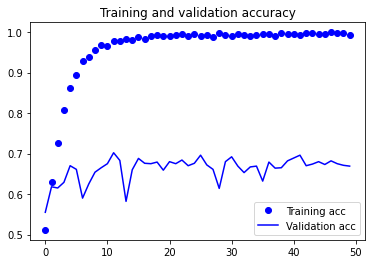

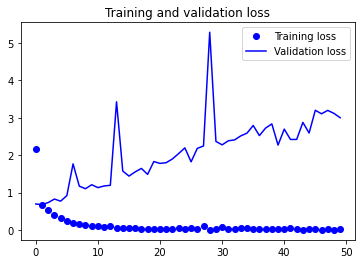

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Using Data Augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data.
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images. Let's get started with an example:

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    ])

These are just a few of the layers available (for more, see the Keras documentation).Let’s quickly go over this code:
1. RandomFlip("horizontal") — Applies horizontal flipping to a random 50% ofthe images that go through it.
2. RandomRotation(0.1)—Rotates the input images by a random value in the range[–10%, +10%] (these are fractions of a full circle—in degrees, the range wouldbe [–36 degrees, +36 degrees]).
3. RandomZoom(0.2)—Zooms  in  or  out  of  the  image  by  a  random  factor  in  therange [-20%, +20%]

Let's take a look at our augmented images:

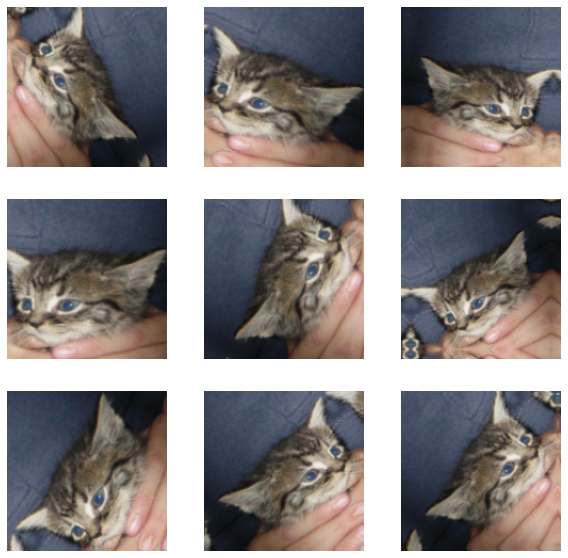

In [ ]:
# Show augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs
that it sees are still heavily intercorrelated, since they come from a small number of original images -- **we cannot produce new information**, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further overcome overfitting, we will also add a `Dropout layer` to our model, right before the densely-connected classifier:

In [ ]:
# Add dropout layer to model and compile

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)   # normalisation
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])


Let's train our network using data augmentation and dropout:

In [ ]:
# Train model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)

Epoch 1/20
100/100 [==============================] - 8s 60ms/step - loss: 0.6929 - acc: 0.5140 - val_loss: 0.6985 - val_acc: 0.5000
Epoch 2/20
100/100 [==============================] - 6s 55ms/step - loss: 0.6884 - acc: 0.5460 - val_loss: 0.6762 - val_acc: 0.5730
Epoch 3/20
100/100 [==============================] - 7s 67ms/step - loss: 0.6733 - acc: 0.5895 - val_loss: 0.6642 - val_acc: 0.5990
Epoch 4/20
100/100 [==============================] - 7s 69ms/step - loss: 0.6680 - acc: 0.5895 - val_loss: 0.6566 - val_acc: 0.6080
Epoch 5/20
100/100 [==============================] - 5s 54ms/step - loss: 0.6590 - acc: 0.6175 - val_loss: 0.6514 - val_acc: 0.6200
Epoch 6/20
100/100 [==============================] - 6s 60ms/step - loss: 0.6442 - acc: 0.6355 - val_loss: 0.6318 - val_acc: 0.6410
Epoch 7/20
100/100 [==============================] - 6s 63ms/step - loss: 0.6305 - acc: 0.6435 - val_loss: 0.7587 - val_acc: 0.5300
Epoch 8/20
100/100 [==============================] - 5s 52ms/step - 

In [ ]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

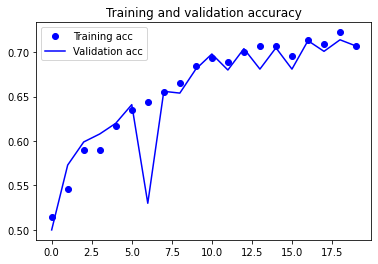

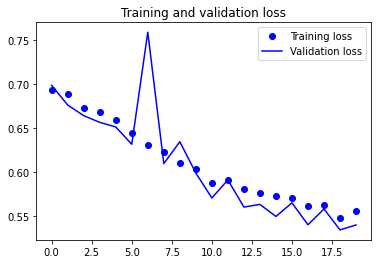

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

In [ ]:
# Evaluating the model on the test set
test_model = keras.models.load_model("/content/cats_and_dogs_small_2.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

50/50 [==============================] - 1s 20ms/step - loss: 0.5879 - acc: 0.6820
Test accuracy: 0.682


# Using a pre-trained convnet

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original
dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. *For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images.* Such portability of learned features across different problems is a key advantage of deep learning
compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes).
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat
vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture
for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent
models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing
any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet,
Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with
feature extraction.

## Feature extraction

**Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples.**
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data
through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

In [ ]:
# Creating the convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

#conv_base = keras.applications.vgg16.VGG16(    weights="imagenet",    include_top=False,    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it,
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already
familiar with.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed:

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model.
However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our
data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [ ]:
import numpy as np
# First method
# Extracts the VGG16 features and corresponding labels

def get_features_and_labels(dataset):
  all_features = []    #empty list of features
  all_labels = []       #empty list of labels

  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


In [ ]:
train_features.shape

(2000, 4, 4, 512)

The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must
flatten them to `(samples, 8192)`:

In [ ]:
# Flatten extracted feature
#train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
#val_features = np.reshape(val_features, (1000, 4 * 4 * 512))
#test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and
labels that we just recorded:

In [ ]:
# Defining and training the densely connected classifier

inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)      #this is for regularization
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(val_features, val_labels))

Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 4.7432 - acc: 0.8130 - val_loss: 1.0232 - val_acc: 0.9360
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 1.7277 - acc: 0.9200 - val_loss: 0.8712 - val_acc: 0.9470
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 1.4102 - acc: 0.9380 - val_loss: 0.8455 - val_acc: 0.9530
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.9948 - acc: 0.9480 - val_loss: 0.7638 - val_acc: 0.9580
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.8970 - acc: 0.9625 - val_loss: 0.7447 - val_acc: 0.9580
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.9232 - acc: 0.9565 - val_loss: 0.8162 - val_acc: 0.9590
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.5511 - acc: 0.9665 - val_loss: 0.7148 - val_acc: 0.9690
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0.

Training is very fast because we only have to deal with two Dense layers — an epoch takes less than one second even on CPU.


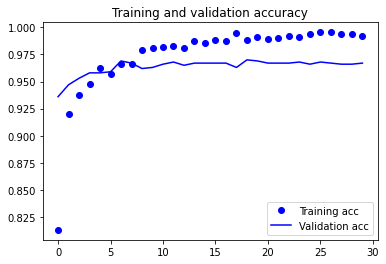

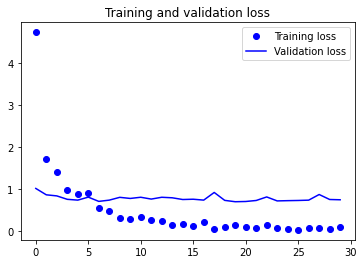

In [ ]:
# Plotting the results

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Here, we reach a validation accuracy of about 97%. Our pretrained model already has the exact knowledge required for the task at hand. This won’t always be the case when you use pretrained features.


## Feature Extraction Together With Data Augmentation

Now  let’s  review  the  second  technique  for  doing  feature  extraction, which is much slower and more expensive, but allows us to use data augmentation  during  training:  creating  a  model  that  chains  the  `conv_base`  with  a  new  `dense classifier`, and training it end to end on the inputs.

In order to do this, we will first *freeze* the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don’t do this, the representations that were previously learned by the convolutional base will be modified during training.

In Keras, we freeze a layer or model by setting its trainable attribute to False.

**Create sequential model with convolutional base**

In [ ]:
# Instantiating the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [ ]:
# Check number of trainable weights before freezing the convolutional base
conv_base.trainable = True

In [ ]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


Now we can create a new model that chains together:
1. A data augmentation stage
2. Our frozen convolutional base and
3. A dense classifier

In [ ]:
# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
     ])

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)     #apply data augmentation
x = keras.applications.vgg16.preprocess_input(x)  #apply input value scaling
x = conv_base(x)     #add the convolutional base
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                           

With this setup, only the weights from the two Dense layers that we added will be trained. That’s a total of four weight tensors: two per layer (i.e., the main weight matrix and the bias vector).

in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.


In [ ]:
# freezing the VGG16 convolutional base
conv_base.trainable = False

In [ ]:
# Check number of trainable weights
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


Now that we have frozen the convolutional base, we can now compile and train our model.

In [ ]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                           

Due to data augmentation, it will take much longer forthe model to start overfitting, so we can train for more epochs—let’s do 50.

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset)

Epoch 1/50
100/100 [==============================] - 14s 123ms/step - loss: 6.9587 - acc: 0.6675 - val_loss: 1.5648 - val_acc: 0.9170
Epoch 2/50
100/100 [==============================] - 12s 122ms/step - loss: 3.7887 - acc: 0.7855 - val_loss: 1.0541 - val_acc: 0.9380
Epoch 3/50
100/100 [==============================] - 12s 121ms/step - loss: 2.9959 - acc: 0.8285 - val_loss: 0.7816 - val_acc: 0.9530
Epoch 4/50
100/100 [==============================] - 12s 121ms/step - loss: 2.6460 - acc: 0.8600 - val_loss: 0.7525 - val_acc: 0.9570
Epoch 5/50
100/100 [==============================] - 12s 118ms/step - loss: 2.3074 - acc: 0.8675 - val_loss: 0.7468 - val_acc: 0.9540
Epoch 6/50
100/100 [==============================] - 12s 117ms/step - loss: 2.2534 - acc: 0.8675 - val_loss: 0.6601 - val_acc: 0.9590
Epoch 7/50
100/100 [==============================] - 12s 117ms/step - loss: 2.0703 - acc: 0.8675 - val_loss: 0.5948 - val_acc: 0.9640
Epoch 8/50
100/100 [==============================] - 1

In [ ]:
model.save('cats_and_dogs_small_3.h5')

Let’s  plot  the  results  again.  As  you  can  see,  we  achieved  a  validation accuracy of over 98%. This is a strong improvement over the previous model.

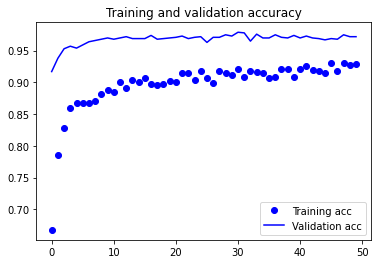

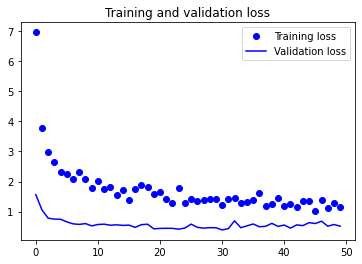

In [ ]:
# Extract performance metrics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot results
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluating the model on the test set
test_model = keras.models.load_model("cats_and_dogs_small_3.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

50/50 [==============================] - 4s 69ms/step - loss: 0.6248 - acc: 0.9710
Test accuracy: 0.971


We have obtained a test accuracy of 97.1%. This is only a modest improvement compared to the previous test accuracy, which is a bit disappointing given the strong results on the validation data. A model’s accuracy always depends on the set of samples you evaluate it on! Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets.


## Fine-tuning a Pretrained Model

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_.
**Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model** (in our case, the fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)



We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`,
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

We’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable. Check image above for details.

**Note**: Top layers are those close to your output later.


In [ ]:
# Freezing all layers until the fourth from the last
conv_base.trainable = True

for layer in conv_base.layers[:-4]:
  layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [ ]:
#  Fine-tuning the model
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

#callbacks = [
    #keras.callbacks.ModelCheckpoint(
        #filepath="fine_tuning.keras",
        #save_best_only=True,
        #monitor="val_loss")]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset)

Epoch 1/30
100/100 [==============================] - 17s 139ms/step - loss: 1.0314 - accuracy: 0.9170 - val_loss: 0.5260 - val_accuracy: 0.9650
Epoch 2/30
100/100 [==============================] - 14s 139ms/step - loss: 0.9354 - accuracy: 0.9125 - val_loss: 0.3963 - val_accuracy: 0.9650
Epoch 3/30
100/100 [==============================] - 14s 139ms/step - loss: 0.8642 - accuracy: 0.9125 - val_loss: 0.3726 - val_accuracy: 0.9630
Epoch 4/30
100/100 [==============================] - 14s 138ms/step - loss: 0.5927 - accuracy: 0.9255 - val_loss: 0.3396 - val_accuracy: 0.9700
Epoch 5/30
100/100 [==============================] - 14s 136ms/step - loss: 0.5555 - accuracy: 0.9295 - val_loss: 0.2914 - val_accuracy: 0.9660
Epoch 6/30
100/100 [==============================] - 14s 137ms/step - loss: 0.5727 - accuracy: 0.9175 - val_loss: 0.2711 - val_accuracy: 0.9710
Epoch 7/30
100/100 [==============================] - 14s 138ms/step - loss: 0.4416 - accuracy: 0.9200 - val_loss: 0.3107 - val_ac

In [ ]:
# Save your model
model.save('cats_and_dogs_small_4.h5')

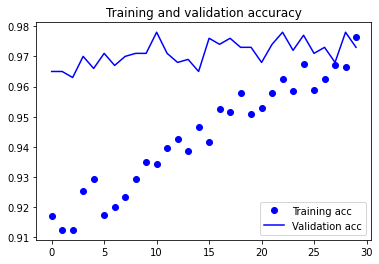

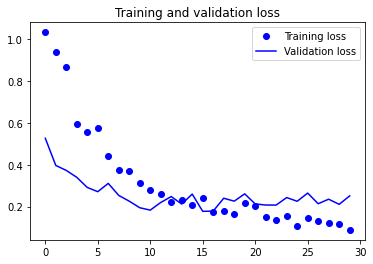

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Smoothing

These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with **exponential moving averages** of these quantities. Here's a trivial utility function to do this:

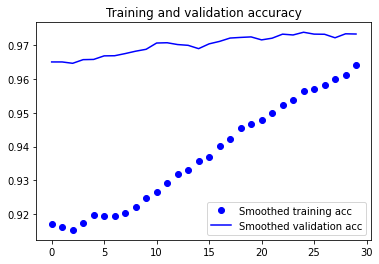

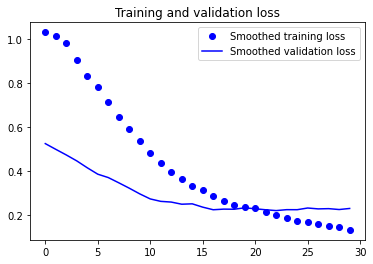

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

**Note** that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [ ]:
model = keras.models.load_model('cats_and_dogs_small_4.h5')
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


50/50 [==============================] - 4s 69ms/step - loss: 0.3201 - accuracy: 0.9570
Test accuracy: 0.957



Here we get a test accuracy of 96%. In the original Kaggle competition around this dataset, this would have been one of the top results.
However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data
available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

# Visualizing what convnets learn - CHAPTER 9 (Section 9.4)

---



It is often said that deep learning models are "black boxes", learning representations that are difficult to extract and present in a
human-readable form. While this is partially true for certain types of deep learning models, it is definitely not true for convnets. The
representations learned by convnets are highly amenable to visualization, in large part because they are _representations of visual
concepts_. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won't
survey all of them, but we will cover three of the most accessible and useful ones:

* Visualizing intermediate convnet outputs ("intermediate activations"). This is useful to understand how successive convnet layers
transform their input, and to get a first idea of the meaning of individual convnet filters.
* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive
to.
* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging
to a given class, and thus allows to localize objects in images.

For the first method -- activation visualization -- we will use the small convnet that we trained from scratch on the cat vs. dog
classification problem two sections ago. For the next two methods, we will use the VGG16 model that we introduced in the previous section.

## Visualizing intermediate activations

In [ ]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

In [ ]:
img_path = './cats_and_dogs_small/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

Let's display our picture:

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs
the activations of all convolution and pooling layers. To do this, we will use the Keras class `Model`. A `Model` is instantiated using two
arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors).

In [ ]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you encounter
a multi-output model. In the general case, a
model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [ ]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

It's a 148x148 feature map with 32 channels. Let's try visualizing the 3rd channel:

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

This channel appears to encode a diagonal edge detector. Let's try the 30th channel -- but note that your own channels may vary, since the
specific filters learned by convolution layers are not deterministic.

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 12], cmap='viridis')
plt.show()

This one looks like a "bright green dot" detector, useful to encode cat eyes. At this point, let's go and plot a complete visualization of
all the activations in the network. We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in
one big image tensor, with channels stacked side by side.

In [ ]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

A few remarkable things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations are still retaining almost all of the
information present in the initial picture.
* As we go higher-up, the activations become increasingly abstract and less visually interpretable. They start encoding higher-level
concepts such as "cat ear" or "cat eye". Higher-up presentations carry increasingly less information about the visual contents of the
image, and increasingly more information related to the class of the image.
* The sparsity of the activations is increasing with the depth of the layer: in the first layer, all filters are activated by the input
image, but in the following layers more and more filters are blank. This means that the pattern encoded by the filter isn't found in the
input image.


We have just evidenced a very important universal characteristic of the representations learned by deep neural networks: the features
extracted by a layer get increasingly abstract with the depth of the layer. The activations of layers higher-up carry less and less
information about the specific input being seen, and more and more information about the target (in our case, the class of the image: cat
or dog).

## Visualizing convnet filters


Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond
to. This can be done with __gradient ascent in input space__: applying __gradient descent__ to the value of the input image of a convnet so
as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen
filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we
will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here's
a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

In [ ]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, we will need the gradient of this loss with respect to the model's input. To do this, we will use the
`gradients` function packaged with the `backend` module of Keras:

In [ ]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]
# grads = K.GradientTape(loss, model.input)[0]

A non-obvious trick to use for the gradient descent process to go smoothly is to normalize the gradient tensor, by dividing it by its L2
norm (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the
input image is always within a same range.

In [ ]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Now we need a way to compute the value of the loss tensor and the gradient tensor, given an input image. We can define a Keras backend
function to do this: `iterate` is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy
tensors: the loss value and the gradient value.

In [ ]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point we can define a Python loop to do stochastic gradient descent:

In [ ]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

The resulting image tensor will be a floating point tensor of shape `(1, 150, 150, 3)`, with values that may not be integer within `[0,
255]`. Hence we would need to post-process this tensor to turn it into a displayable image. We do it with the following straightforward
utility function:

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we have all the pieces, let's put them together into a Python function that takes as input a layer name and a filter index, and that
returns a valid image tensor representing the pattern that maximizes the activation the specified filter:

In [ ]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])

    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

Let's try this:

In [ ]:
plt.imshow(generate_pattern('block3_conv1', 1))
plt.show()

It seems that filter 0 in layer `block3_conv1` is responsive to a polka dot pattern.

Now the fun part: we can start visualising every single filter in every layer. For simplicity, we will only look at the first 64 filters in
each layer, and will only look at the first layer of each convolution block (block1_conv1, block2_conv1, block3_conv1, block4_conv1,
block5_conv1). We will arrange the outputs on a 8x8 grid of 64x64 filter patterns, with some black margins between each filter pattern.

In [ ]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

The filters in these convnet filter banks get increasingly complex and refined as we go higher-up
in the model:

* The filters from the first layer in the model (`block1_conv1`) encode simple directional edges and colors (or colored edges in some
cases).
* The filters from `block2_conv1` encode simple textures made from combinations of edges and colors.
* The filters in higher-up layers start resembling textures found in natural images: feathers, eyes, leaves, etc.

## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification
mistake. It also allows you to locate specific objects in an image.

In [ ]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative
Commons license):

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = './creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


The top-3 classes predicted for this image are:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector
that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

In [ ]:
np.argmax(preds[0])

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [ ]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('./elephant_cam.jpg', superimposed_img)

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can
tell the difference between African and Indian elephants.
